In [1]:
import os
import cv2
import json
import sympy
import sympy.printing  # ensure submodule is imported
sympy.printing = sympy.printing  # attach as attribute explicitly
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torchvision.ops import FeaturePyramidNetwork

from scipy.optimize import linear_sum_assignment

import albumentations as A
import matplotlib.pyplot as plt


from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import MaskRCNN
from sklearn.model_selection import train_test_split
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F_transforms

/usr/local/lib/python3.11/dist-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


In [2]:
# Checking GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def analyze_data_structure():
    base_path = '/kaggle/input/recodai-luc-scientific-image-forgery-detection'
    
    # Checking train images
    train_authentic_path = os.path.join(base_path, 'train_images/authentic')
    train_forged_path = os.path.join(base_path, 'train_images/forged')
    train_masks_path = os.path.join(base_path, 'train_masks')
    test_images_path = os.path.join(base_path, 'test_images')
    supp_forged_path = os.path.join(base_path, 'supplemental_images')
    supp_masks_path = os.path.join(base_path, 'supplemental_masks')
    
    print(f"Authentic images: {len(os.listdir(train_authentic_path))}")
    print(f"Forged images: {len(os.listdir(train_forged_path))}")
    print(f"Masks: {len(os.listdir(train_masks_path))}")
    print(f"Test images: {len(os.listdir(test_images_path))}")

    print(f"Supp forged images: {len(os.listdir(supp_forged_path))}")
    print(f"Supp masks: {len(os.listdir(supp_masks_path))}")
    
    # Let's analyze some examples of masks
    mask_files = os.listdir(train_masks_path)[:5]
    print(f"Examples of mask files: {mask_files}")
    
    # Checking the mask format
    sample_mask = np.load(os.path.join(train_masks_path, mask_files[0]))
    print(f"Mask format: {sample_mask.shape}, dtype: {sample_mask.dtype}")
    
    test_files = os.listdir(test_images_path)
    print(f"Test images: {test_files}")
    
    return {
        'train_authentic': train_authentic_path,
        'train_forged': train_forged_path,
        'train_masks': train_masks_path,
        'test_images': test_images_path,
        'supp_forged': supp_forged_path,
        'supp_masks' : supp_masks_path
    }

paths = analyze_data_structure()

Authentic images: 2377
Forged images: 2751
Masks: 2751
Test images: 1
Supp forged images: 48
Supp masks: 48
Examples of mask files: ['59069.npy', '64134.npy', '18929.npy', '36106.npy', '422.npy']
Mask format: (1, 512, 711), dtype: uint8
Test images: ['45.png']


In [4]:
class ForgeryDataset(Dataset):
    def __init__(
        self,
        authentic_path,
        forged_path,
        masks_path,
        supp_forged_path=None,
        supp_masks_path=None,
        transform=None,
        is_train=True,
    ):
        self.transform = transform
        self.is_train = is_train
        
        # Collect all data samples
        self.samples = []
        
        # Authentic images
        for file in os.listdir(authentic_path):
            img_path = os.path.join(authentic_path, file)
            base_name = file.split('.')[0]
            mask_path = os.path.join(masks_path, f"{base_name}.npy")
            
            self.samples.append({
                'image_path': img_path,
                'mask_path': mask_path,
                'is_forged': False,
                'image_id': base_name
            })
        
        # Forged images (original)
        for file in os.listdir(forged_path):
            img_path = os.path.join(forged_path, file)
            base_name = file.split('.')[0]
            mask_path = os.path.join(masks_path, f"{base_name}.npy")
            
            self.samples.append({
                'image_path': img_path,
                'mask_path': mask_path,
                'is_forged': True,
                'image_id': base_name
            })

        # Supplemental forged images (all forged)
        if supp_forged_path is not None and supp_masks_path is not None:
            for file in os.listdir(supp_forged_path):
                img_path = os.path.join(supp_forged_path, file)
                base_name = file.split('.')[0]
                mask_path = os.path.join(supp_masks_path, f"{base_name}.npy")
                
                self.samples.append({
                    'image_path': img_path,
                    'mask_path': mask_path,
                    'is_forged': True,
                    'image_id': base_name
                })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image
        image = Image.open(sample['image_path']).convert('RGB')
        image = np.array(image)  # (H, W, 3)
        
        # Load and process mask
        if os.path.exists(sample['mask_path']):
            mask = np.load(sample['mask_path'])
            
            # Handle multi-channel masks: MUST be channel-first (C, H, W)
            if mask.ndim == 3:
                # Expect small channel dimension as first dim
                if mask.shape[0] <= 10 and mask.shape[1:] == image.shape[:2]:
                    mask = np.any(mask, axis=0)
                else:
                    raise ValueError(
                        f"Expected channel-first mask (C, H, W) with small C. Got {mask.shape}"
                    )
            
            mask = (mask > 0).astype(np.uint8)
        else:
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    
        # Shape validation
        assert image.shape[:2] == mask.shape, f"Shape mismatch: img {image.shape}, mask {mask.shape}"
        
        # Apply transformations
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        else:
            image = F_transforms.to_tensor(image)
            mask = torch.tensor(mask, dtype=torch.uint8)
        
        # Prepare targets for Mask2Former
        if sample['is_forged'] and mask.sum() > 0:
            boxes, labels, masks = self.mask_to_boxes(mask)
            
            target = {
                'boxes': boxes,
                'labels': labels,
                'masks': masks,
                'image_id': torch.tensor([idx]),
                'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
            }
            target['image_label'] = torch.tensor(1.0)   # forged
        else:
            # For authentic images or images without masks
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros(0, dtype=torch.int64),
                'masks': torch.zeros((0, image.shape[1], image.shape[2]), dtype=torch.uint8),
                'image_id': torch.tensor([idx]),
                'area': torch.zeros(0, dtype=torch.float32),
                'iscrowd': torch.zeros((0,), dtype=torch.int64)
            }
            target['image_label'] = torch.tensor(0.0)   # authentic
        return image, target
    
    def mask_to_boxes(self, mask):
        """Convert segmentation mask to bounding boxes for Mask2Former"""
        if isinstance(mask, torch.Tensor):
            mask_np = mask.numpy()
        else:
            mask_np = mask
        
        # Find contours in the mask
        contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        boxes = []
        masks = []
        
        for contour in contours:
            if len(contour) > 0:
                x, y, w, h = cv2.boundingRect(contour)
                # Filter out very small regions
                if w > 5 and h > 5:
                    boxes.append([x, y, x + w, y + h])
                    # Create binary mask for this contour
                    contour_mask = np.zeros_like(mask_np)
                    cv2.fillPoly(contour_mask, [contour], 1)
                    masks.append(contour_mask)
        
        if boxes:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.ones((len(boxes),), dtype=torch.int64)
            masks = torch.tensor(np.array(masks), dtype=torch.uint8)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
            masks = torch.zeros((0, mask_np.shape[0], mask_np.shape[1]), dtype=torch.uint8)
        
        return boxes, labels, masks

In [5]:
# Transformations for learning, ImageNet standards
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

full_dataset = ForgeryDataset(
    paths['train_authentic'],
    paths['train_forged'],
    paths['train_masks'],
    supp_forged_path=paths['supp_forged'],
    supp_masks_path=paths['supp_masks'],
    transform=train_transform
)

# Split into train/val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Use val transforms for validation subset
val_dataset.dataset.transform = val_transform

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")


Train samples: 4140
Val samples: 1036


In [6]:
class ConvNeXtFPNBackbone(nn.Module):
    """
    ConvNeXt-T backbone with FPN neck.
    Uses outputs from indices [1, 3, 5, 7], which have channels
    [96, 192, 384, 768] according to your debug print.
    """
    def __init__(self, out_channels=256, train_backbone=True):
        super().__init__()
        try:
            backbone = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        except Exception:
            backbone = convnext_tiny(weights=None)

        self.body = backbone.features  # modules 0..7

        # Use the last block of each resolution stage:
        #  1: 96 @ 64×64
        #  3: 192 @ 32×32
        #  5: 384 @ 16×16
        #  7: 768 @  8×8
        self.out_indices = (1, 3, 5, 7)

        in_channels_list = [96, 192, 384, 768]
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
        )

        if not train_backbone:
            for p in self.body.parameters():
                p.requires_grad = False

    def forward(self, x):
        feats = []
        out = x
        for i, layer in enumerate(self.body):
            out = layer(out)
            if i in self.out_indices:
                feats.append(out)

        # feats is a list of 4 tensors with channels [96, 192, 384, 768]
        feat_dict = {str(i): f for i, f in enumerate(feats)}  # keys "0","1","2","3"
        fpn_out = self.fpn(feat_dict)  # dict of {level_name: [B, C, H, W]}

        # Sort by level name to keep consistent order
        levels = [fpn_out[k] for k in sorted(fpn_out.keys(), key=int)]
        return levels  # [P2, P3, P4, P5], all with C=out_channels


In [7]:
backbone_fpn = ConvNeXtFPNBackbone(out_channels=256, train_backbone=False).eval()

x = torch.randn(1, 3, 256, 256)

with torch.no_grad():
    levels = backbone_fpn(x)
    print("=== FPN levels ===")
    for i, f in enumerate(levels):
        print(f"Level {i}: {tuple(f.shape)}")

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


=== FPN levels ===
Level 0: (1, 256, 64, 64)
Level 1: (1, 256, 32, 32)
Level 2: (1, 256, 16, 16)
Level 3: (1, 256, 8, 8)


In [8]:
class DetrTransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=False)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=False)

        # FFN
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.dropout_ffn = nn.Dropout(dropout)

        if activation == "relu":
            self.activation = F.relu
        elif activation == "gelu":
            self.activation = F.gelu
        else:
            raise ValueError(f"Unsupported activation: {activation}")

    def with_pos(self, x, pos):
        if pos is None:
            return x
        return x + pos

    def forward(
        self,
        tgt,                      # [Q, B, C]
        memory,                   # [S, B, C]
        tgt_pos=None,             # [Q, B, C] or None
        memory_pos=None,          # [S, B, C] or None
        tgt_mask=None,
        memory_mask=None,
        tgt_key_padding_mask=None,
        memory_key_padding_mask=None,
    ):
        # ---- Self-attention (queries attend to themselves) ----
        q = k = self.with_pos(tgt, tgt_pos)
        tgt2, _ = self.self_attn(
            q, k, value=tgt,
            attn_mask=tgt_mask,
            key_padding_mask=tgt_key_padding_mask,
        )
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)

        # ---- Cross-attention (queries attend to encoder memory) ----
        q = self.with_pos(tgt, tgt_pos)
        k = self.with_pos(memory, memory_pos)
        tgt2, _ = self.multihead_attn(
            q, k, value=memory,
            attn_mask=memory_mask,
            key_padding_mask=memory_key_padding_mask,
        )
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)

        # ---- Feed-forward ----
        tgt2 = self.linear2(self.dropout_ffn(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)

        return tgt


In [9]:
class DetrTransformerDecoder(nn.Module):
    def __init__(self, decoder_layer, num_layers, norm=None, return_intermediate=False):
        super().__init__()
        self.layers = nn.ModuleList([decoder_layer for _ in range(num_layers)])
        self.num_layers = num_layers
        self.norm = norm
        self.return_intermediate = return_intermediate

    def forward(
        self,
        tgt,                      # [Q, B, C]
        memory,                   # [S, B, C]
        tgt_pos=None,             # [Q, B, C] or None
        memory_pos=None,          # [S, B, C] or None
        tgt_mask=None,
        memory_mask=None,
        tgt_key_padding_mask=None,
        memory_key_padding_mask=None,
    ):
        output = tgt
        intermediate = []

        for layer in self.layers:
            output = layer(
                output,
                memory,
                tgt_pos=tgt_pos,
                memory_pos=memory_pos,
                tgt_mask=tgt_mask,
                memory_mask=memory_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask,
            )
            if self.return_intermediate:
                intermediate.append(output)

        if self.norm is not None:
            output = self.norm(output)
            if self.return_intermediate:
                intermediate[-1] = output

        if self.return_intermediate:
            # [num_layers, Q, B, C]
            return torch.stack(intermediate)

        # [1, Q, B, C] to match DETR’s interface
        return output.unsqueeze(0)


In [10]:
class SimpleTransformerDecoder(nn.Module):
    def __init__(
        self,
        d_model=256,
        nhead=8,
        num_layers=6,
        dim_feedforward=2048,
        dropout=0.1,
        num_queries=100,
    ):
        super().__init__()
        self.num_queries = num_queries

        # learned object queries (like DETR)
        self.query_embed = nn.Embedding(num_queries, d_model)

        layer = DetrTransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.decoder = DetrTransformerDecoder(
            decoder_layer=layer,
            num_layers=num_layers,
            norm=nn.LayerNorm(d_model),
            return_intermediate=True,
        )

    def forward(self, feats, pos_list):
        """
        feats:    list of [B, C, H, W]
        pos_list: list of [B, C, H, W] (positional encodings for each feat)
        """
        srcs = []
        pos_embs = []
        for feat, pos in zip(feats, pos_list):
            # [B, C, H, W] -> [HW, B, C]
            srcs.append(feat.flatten(2).permute(2, 0, 1))
            pos_embs.append(pos.flatten(2).permute(2, 0, 1))

        memory = torch.cat(srcs, dim=0)        # [S, B, C]
        memory_pos = torch.cat(pos_embs, dim=0)  # [S, B, C]

        B = memory.size(1)
        # [Q, B, C] query positions
        query_pos = self.query_embed.weight.unsqueeze(1).repeat(1, B, 1)
        tgt = torch.zeros_like(query_pos)  # initial target is zeros; queries in query_pos

        hs = self.decoder(
            tgt=tgt,
            memory=memory,
            tgt_pos=query_pos,
            memory_pos=memory_pos,
        )
        # [num_layers, Q, B, C] -> [num_layers, B, Q, C]
        hs = hs.permute(0, 2, 1, 3)
        return hs


In [11]:
class PositionEmbeddingSine(nn.Module):
    """
    Standard sine-cosine positional encoding as in DETR.
    """
    def __init__(self, num_pos_feats=128, temperature=10000, normalize=False, scale=None):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.normalize = normalize
        self.scale = 2 * torch.pi if scale is None else scale

    def forward(self, x):
        # x: [B, C, H, W]
        B, C, H, W = x.shape
        device = x.device

        y_embed = torch.arange(H, device=device).unsqueeze(1).repeat(1, W)
        x_embed = torch.arange(W, device=device).unsqueeze(0).repeat(H, 1)

        y_embed = y_embed.float()
        x_embed = x_embed.float()

        if self.normalize:
            eps = 1e-6
            y_embed = y_embed / (H - 1 + eps) * self.scale
            x_embed = x_embed / (W - 1 + eps) * self.scale

        dim_t = torch.arange(self.num_pos_feats, device=device).float()
        dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)

        pos_x = x_embed[..., None] / dim_t
        pos_y = y_embed[..., None] / dim_t
        pos_x = torch.stack([pos_x[..., 0::2].sin(), pos_x[..., 1::2].cos()], dim=-1).flatten(-2)
        pos_y = torch.stack([pos_y[..., 0::2].sin(), pos_y[..., 1::2].cos()], dim=-1).flatten(-2)

        pos = torch.cat([pos_y, pos_x], dim=-1)  # [H, W, 2*num_pos_feats]
        pos = pos.permute(2, 0, 1).unsqueeze(0).expand(B, -1, -1, -1)  # [B, C, H, W]
        return pos


In [12]:
# Instantiate ConvNeXt-Tiny exactly as in the Mask2Former model
try:
    backbone = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
except Exception:
    backbone = convnext_tiny(weights=None)

backbone.eval()

# Dummy input
x = torch.randn(1, 3, 256, 256)

with torch.no_grad():
    out = x
    print("Input:", x.shape)
    for i, layer in enumerate(backbone.features):
        out = layer(out)
        print(f"features[{i}] output:", out.shape)


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


Input: torch.Size([1, 3, 256, 256])
features[0] output: torch.Size([1, 96, 64, 64])
features[1] output: torch.Size([1, 96, 64, 64])
features[2] output: torch.Size([1, 192, 32, 32])
features[3] output: torch.Size([1, 192, 32, 32])
features[4] output: torch.Size([1, 384, 16, 16])
features[5] output: torch.Size([1, 384, 16, 16])
features[6] output: torch.Size([1, 768, 8, 8])
features[7] output: torch.Size([1, 768, 8, 8])


In [13]:
backbone_fpn = ConvNeXtFPNBackbone(out_channels=256, train_backbone=False).eval()

x = torch.randn(1, 3, 256, 256)

with torch.no_grad():
    feats = []
    out = x
    print("=== Debug ConvNeXtFPNBackbone ===")
    for i, layer in enumerate(backbone_fpn.body):
        out = layer(out)
        print(f"body[{i}] output:", out.shape)
    print("---- FPN inputs (as dict keys / shapes) ----")
    # Re-run forward like in the class, but instrumented
    out = x
    feat_list = []
    for i, layer in enumerate(backbone_fpn.body):
        out = layer(out)
        if i in backbone_fpn.out_indices:
            feat_list.append((i, out))
    for idx, feat in feat_list:
        print(f"Selected feature index {idx} -> {feat.shape}")


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


=== Debug ConvNeXtFPNBackbone ===
body[0] output: torch.Size([1, 96, 64, 64])
body[1] output: torch.Size([1, 96, 64, 64])
body[2] output: torch.Size([1, 192, 32, 32])
body[3] output: torch.Size([1, 192, 32, 32])
body[4] output: torch.Size([1, 384, 16, 16])
body[5] output: torch.Size([1, 384, 16, 16])
body[6] output: torch.Size([1, 768, 8, 8])
body[7] output: torch.Size([1, 768, 8, 8])
---- FPN inputs (as dict keys / shapes) ----
Selected feature index 1 -> torch.Size([1, 96, 64, 64])
Selected feature index 3 -> torch.Size([1, 192, 32, 32])
Selected feature index 5 -> torch.Size([1, 384, 16, 16])
Selected feature index 7 -> torch.Size([1, 768, 8, 8])


In [14]:
with torch.no_grad():
    feat_dict = {str(i): f for i, (_, f) in enumerate(feat_list)}
    fpn_out = backbone_fpn.fpn(feat_dict)
    print("---- FPN outputs ----")
    for k in sorted(fpn_out.keys(), key=int):
        print(f"FPN level {k} -> {fpn_out[k].shape}")


---- FPN outputs ----
FPN level 0 -> torch.Size([1, 256, 64, 64])
FPN level 1 -> torch.Size([1, 256, 32, 32])
FPN level 2 -> torch.Size([1, 256, 16, 16])
FPN level 3 -> torch.Size([1, 256, 8, 8])


In [15]:
class Mask2FormerForgeryModel(nn.Module):
    """
    Instance-Seg Transformer (Mask2Former-style) + Authenticity Gate baseline.
    """
    def __init__(
        self,
        num_queries=15,
        d_model=256,
        nhead=8,
        num_decoder_layers=6,
        mask_dim=256,
        backbone_trainable=True,
        authenticity_penalty_weight=5.0,
    ):
        super().__init__()
        self.num_queries = num_queries
        self.d_model = d_model
        self.mask_dim = mask_dim
        self.authenticity_penalty_weight = authenticity_penalty_weight

        # Backbone + FPN
        self.backbone = ConvNeXtFPNBackbone(out_channels=d_model, train_backbone=backbone_trainable)

        # Transformer decoder
        self.position_encoding = PositionEmbeddingSine(d_model // 2, normalize=True)
        self.transformer_decoder = SimpleTransformerDecoder(
            d_model=256,
            nhead=8,
            num_layers=6,
            dim_feedforward=2048,
            dropout=0.1,
            num_queries=num_queries,
        )

        # Pixel decoder: project highest-res FPN level to mask feature space
        self.mask_feature_proj = nn.Conv2d(d_model, mask_dim, kernel_size=1)

        # Instance heads
        self.class_head = nn.Linear(d_model, 1)  # forgery vs ignore, per query
        self.mask_embed_head = nn.Linear(d_model, mask_dim)

        # Image-level authenticity head (global pooled high-level feat)
        self.img_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(d_model, d_model),
            nn.ReLU(inplace=True),
            nn.Linear(d_model, 1),
        )

    def forward(self, images, targets=None):
        """
        images: Tensor [B, 3, H, W]
        targets: list[dict], each with:
          - 'masks': [N_gt, H, W] binary mask tensor
          - 'image_label': scalar tensor 0 (authentic) or 1 (forged)
        Returns:
          - if training: dict of losses
          - if inference: list[dict] with masks, mask_scores, mask_forgery_scores, image_authenticity
        """
        if isinstance(images, list):
            images = torch.stack(images, dim=0)

        B = images.shape[0]

        # Backbone + FPN
        fpn_feats = self.backbone(images)  # [P2, P3, P4, P5]
        # Use highest-res level (P2) for mask features
        mask_feats = self.mask_feature_proj(fpn_feats[0])  # [B, mask_dim, Hm, Wm]
        pos_list = [self.position_encoding(x) for x in fpn_feats]

        # Transformer on multi-scale features
        hs_all = self.transformer_decoder(fpn_feats, pos_list)  # [num_layers, B, Q, C]
        hs = hs_all[-1]                                         # last layer: [B, Q, C]

        # Heads
        class_logits    = self.class_head(hs).squeeze(-1)       # [B, Q]
        mask_embeddings = self.mask_embed_head(hs)              # [B, Q, mask_dim]


        # Produce mask logits via dot-product
        # mask_feats: [B, mask_dim, Hm, Wm]; mask_emb: [B, Q, mask_dim]
        mask_logits = torch.einsum("bqc, bchw -> bqhw", mask_embeddings, mask_feats)

        # Image-level authenticity from highest-level FPN feature (P5)
        high_level_feat = fpn_feats[-1]  # [B, C, Hh, Wh]
        img_logits = self.img_head(high_level_feat)  # [B, 1]
        img_logits = img_logits.squeeze(-1)          # [B]

        if targets is not None:
            return self.compute_losses(mask_logits, class_logits, img_logits, targets)
        else:
            return self.inference(mask_logits, class_logits, img_logits)

    # ------------------- Losses & matching -------------------

    def compute_losses(self, mask_logits, class_logits, img_logits, targets):
        """
        mask_logits: [B, Q, Hm, Wm]
        class_logits: [B, Q]  (forgery vs ignore)
        img_logits: [B]
        targets: list[dict]
        """
        B, Q, Hm, Wm = mask_logits.shape

        # Hungarian matching per image
        indices = []
        for b in range(B):
            tgt_masks = targets[b]["masks"]  # [N_gt, H, W] or [0, ...] if authentic
            if tgt_masks.numel() == 0:
                indices.append((torch.empty(0, dtype=torch.long, device=mask_logits.device),
                                torch.empty(0, dtype=torch.long, device=mask_logits.device)))
                continue

            # Downsample GT masks to mask resolution
            tgt_masks_resized = F.interpolate(
                tgt_masks.unsqueeze(1).float(),
                size=(Hm, Wm),
                mode="nearest"
            ).squeeze(1)  # [N_gt, Hm, Wm]

            pred = mask_logits[b]  # [Q, Hm, Wm]
            cost = self.match_cost(pred, tgt_masks_resized)  # [N_gt, Q]

            tgt_ind, pred_ind = linear_sum_assignment(cost.detach().cpu().numpy())
            tgt_ind = torch.as_tensor(tgt_ind, dtype=torch.long, device=mask_logits.device)
            pred_ind = torch.as_tensor(pred_ind, dtype=torch.long, device=mask_logits.device)
            indices.append((pred_ind, tgt_ind))

        # Mask losses (Dice + BCE) on matched pairs
        loss_mask = 0.0
        loss_dice = 0.0
        num_instances = 0

        for b in range(B):
            pred_ind, tgt_ind = indices[b]
            if len(pred_ind) == 0:
                continue

            tgt_masks = targets[b]["masks"]
            tgt_masks_resized = F.interpolate(
                tgt_masks.unsqueeze(1).float(),
                size=(Hm, Wm),
                mode="nearest"
            ).squeeze(1)  # [N_gt, Hm, Wm]

            pred_masks = mask_logits[b, pred_ind]        # [M, Hm, Wm]
            gt_masks = tgt_masks_resized[tgt_ind]        # [M, Hm, Wm]

            loss_mask += self.sigmoid_ce_loss(pred_masks, gt_masks).sum()
            loss_dice += self.dice_loss(pred_masks, gt_masks).sum()
            num_instances += pred_ind.numel()

        if num_instances > 0:
            loss_mask = loss_mask / num_instances
            loss_dice = loss_dice / num_instances
        else:
            loss_mask = mask_logits.sum() * 0.0
            loss_dice = mask_logits.sum() * 0.0

        # Mask-level classification BCE
        # All GT instances are "forgery" (1). Unmatched predictions are ignore (0).
        class_targets = torch.zeros_like(class_logits)  # [B, Q]
        for b in range(B):
            pred_ind, tgt_ind = indices[b]
            if len(pred_ind) > 0:
                class_targets[b, pred_ind] = 1.0

        loss_cls = F.binary_cross_entropy_with_logits(
            class_logits,
            class_targets,
        )

        # Image-level authenticity loss
        img_targets = torch.stack([t["image_label"].float() for t in targets]).to(img_logits.device)  # [B]
        loss_img = F.binary_cross_entropy_with_logits(img_logits, img_targets)

        # Authenticity penalty: if authentic image (y=0) has non-empty predicted forgery mask
        with torch.no_grad():
            mask_probs = torch.sigmoid(mask_logits)        # [B, Q, Hm, Wm]
            cls_probs = torch.sigmoid(class_logits)        # [B, Q]
            # Take only masks with high forgery prob
            forgery_mask = cls_probs > 0.5                 # [B, Q]

        penalty = 0.0
        for b in range(B):
            if img_targets[b] < 0.5:  # authentic
                if mask_logits.shape[1] == 0:
                    continue
                # Select predicted forgery masks
                if forgery_mask[b].any():
                    m = mask_probs[b, forgery_mask[b]]  # [K, Hm, Wm]
                    # L1 norm as "area"
                    penalty += m.mean()

        if isinstance(penalty, float):
            penalty = mask_logits.sum() * 0.0
        loss_auth_penalty = self.authenticity_penalty_weight * penalty / max(B, 1)

        losses = {
            "loss_mask_bce": loss_mask,
            "loss_mask_dice": loss_dice,
            "loss_mask_cls": loss_cls,
            "loss_img_auth": loss_img,
            "loss_auth_penalty": loss_auth_penalty,
        }

        return losses

    def match_cost(self, pred_masks, tgt_masks):
        """
        pred_masks: [Q, H, W]
        tgt_masks: [N_gt, H, W]
        Returns cost matrix [N_gt, Q]
        """
        Q, H, W = pred_masks.shape
        N = tgt_masks.shape[0]

        pred_flat = pred_masks.flatten(1)  # [Q, HW]
        tgt_flat = tgt_masks.flatten(1)    # [N, HW]

        # BCE cost
        pred_logits = pred_flat.unsqueeze(0)             # [1, Q, HW]
        tgt = tgt_flat.unsqueeze(1)                      # [N, 1, HW]
        bce = F.binary_cross_entropy_with_logits(
            pred_logits.expand(N, -1, -1),
            tgt.expand(-1, Q, -1),
            reduction="none",
        ).mean(-1)  # [N, Q]

        # Dice cost
        pred_prob = pred_flat.sigmoid()
        numerator = 2 * (pred_prob.unsqueeze(0) * tgt_flat.unsqueeze(1)).sum(-1)
        denominator = pred_prob.unsqueeze(0).sum(-1) + tgt_flat.unsqueeze(1).sum(-1) + 1e-6
        dice = 1.0 - (numerator + 1e-6) / (denominator)

        cost = bce + dice
        return cost

    @staticmethod
    def sigmoid_ce_loss(inputs, targets):
        """
        BCE on logits, per-instance mean.
        inputs: [M, H, W], targets: [M, H, W]
        """
        return F.binary_cross_entropy_with_logits(inputs, targets, reduction="none").mean(dim=(1, 2))

    @staticmethod
    def dice_loss(inputs, targets, eps=1e-6):
        """
        Soft dice loss on logits.
        inputs: [M, H, W], targets: [M, H, W]
        """
        inputs = inputs.sigmoid()
        inputs = inputs.flatten(1)
        targets = targets.flatten(1)

        numerator = 2 * (inputs * targets).sum(1)
        denominator = inputs.sum(1) + targets.sum(1) + eps
        loss = 1 - (numerator + eps) / (denominator)
        return loss

    # ------------------- Inference -------------------

    def inference(self, mask_logits, class_logits, img_logits, mask_threshold=0.5, cls_threshold=0.5):
        """
        Returns list of dicts per image:
          - 'masks': [K, Hm, Wm] uint8
          - 'mask_scores': [K]
          - 'mask_forgery_scores': [K]
          - 'image_authenticity': float in [0,1], prob of "forged"
        Authenticity gate: if prob(authentic) > 0.5, masks list is empty.
        """
        B, Q, Hm, Wm = mask_logits.shape
        mask_probs = torch.sigmoid(mask_logits)
        cls_probs = torch.sigmoid(class_logits)
        img_probs = torch.sigmoid(img_logits)  # prob "forged"

        outputs = []
        for b in range(B):
            forged_prob = img_probs[b].item()
            authentic_prob = 1.0 - forged_prob

            if authentic_prob > 0.5:
                # Authenticity gate: suppress all masks
                outputs.append({
                    "masks": torch.zeros((0, Hm, Wm), dtype=torch.uint8, device=mask_logits.device),
                    "mask_scores": torch.empty(0, device=mask_logits.device),
                    "mask_forgery_scores": torch.empty(0, device=mask_logits.device),
                    "image_authenticity": forged_prob,
                })
                continue

            # Keep masks with high forgery prob
            keep = cls_probs[b] > cls_threshold
            if keep.sum() == 0:
                outputs.append({
                    "masks": torch.zeros((0, Hm, Wm), dtype=torch.uint8, device=mask_logits.device),
                    "mask_scores": torch.empty(0, device=mask_logits.device),
                    "mask_forgery_scores": torch.empty(0, device=mask_logits.device),
                    "image_authenticity": forged_prob,
                })
                continue

            masks_b = (mask_probs[b, keep] > mask_threshold).to(torch.uint8)  # [K, Hm, Wm]
            scores_b = mask_probs[b, keep].flatten(1).mean(-1)                # avg mask prob
            cls_b = cls_probs[b, keep]

            outputs.append({
                "masks": masks_b,
                "mask_scores": scores_b,
                "mask_forgery_scores": cls_b,
                "image_authenticity": forged_prob,
            })

        return outputs

model = Mask2FormerForgeryModel(num_queries=15, d_model=256).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

for images, targets in train_loader:
    images = [img.to(device) for img in images]
    for t in targets:
        t['masks'] = t['masks'].to(device)
        t['image_label'] = t['image_label'].to(device)

    loss_dict = model(images, targets)
    loss = sum(loss_dict.values())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


In [16]:
# ==== Sanity / shape checks for encoder/decoder/model/loss/train/val ====
print(f"Using device: {device}")

# Small dummy batch
B, C, H, W = 2, 3, 128, 128
dummy_imgs = torch.randn(B, C, H, W, device=device)

# -------------------------------------------------------------------------
# 1) Instantiate model
# -------------------------------------------------------------------------
model = Mask2FormerForgeryModel(num_queries=15, d_model=256).to(device)
model.eval()
print("\n[Model] num_queries:", model.num_queries)

# -------------------------------------------------------------------------
# 2) Encoder: ConvNeXt + FPN features
# -------------------------------------------------------------------------
with torch.no_grad():
    fpn_feats = model.backbone(dummy_imgs)  # list of feature maps

print("\n[Encoder / FPN]")
for i, f in enumerate(fpn_feats):
    print(f"  P{i}: {tuple(f.shape)}")
assert len(fpn_feats) >= 1, "Backbone/FPN returned no feature maps"

# -------------------------------------------------------------------------
# 3) Positional encodings + Transformer decoder
# -------------------------------------------------------------------------
with torch.no_grad():
    pos_list = [model.position_encoding(f) for f in fpn_feats]
    hs_all = model.transformer_decoder(fpn_feats, pos_list)  # [num_layers, B, Q, C]
    hs = hs_all[-1]                                          # [B, Q, C]

print("\n[Decoder]")
print("  hs_all shape (num_layers, B, Q, C):", tuple(hs_all.shape))
print("  hs last layer shape (B, Q, C):", tuple(hs.shape))

# -------------------------------------------------------------------------
# 4) Build dummy targets and run full forward (training mode -> losses)
# -------------------------------------------------------------------------
dummy_targets = []

# sample 0: forged image with 2 GT instances
masks0 = torch.zeros(2, H, W, device=device)
masks0[0, H // 4 : H // 2, W // 4 : W // 2] = 1
masks0[1, H // 2 : 3 * H // 4, W // 2 : 3 * W // 4] = 1
dummy_targets.append({
    "masks": masks0,
    "image_label": torch.tensor(1.0, device=device),
})

# sample 1: authentic image with no GT masks
masks1 = torch.zeros(0, H, W, device=device)
dummy_targets.append({
    "masks": masks1,
    "image_label": torch.tensor(0.0, device=device),
})

model.train()
loss_dict = model(dummy_imgs, dummy_targets)
print("\n[Forward + losses (train mode)]")
for k, v in loss_dict.items():
    print(f"  {k}: {float(v):.4f}")
total_loss = sum(loss_dict.values())
print("  total loss:", float(total_loss))

# -------------------------------------------------------------------------
# 5) Direct loss helper: match_cost sanity
# -------------------------------------------------------------------------
with torch.no_grad():
    pred_masks = torch.randn(4, H, W, device=device)                # Q=4
    tgt_masks = (torch.rand(3, H, W, device=device) > 0.5).float()  # N_gt=3
    cost = model.match_cost(pred_masks, tgt_masks)

print("\n[match_cost]")
print("  cost shape (N_gt, Q):", tuple(cost.shape))

# -------------------------------------------------------------------------
# 6) Inference forward (no targets) to check outputs
# -------------------------------------------------------------------------
model.eval()
with torch.no_grad():
    outputs = model(dummy_imgs, targets=None)

print("\n[Forward (eval mode / inference)]")
print("  batch size:", len(outputs))
for b, out in enumerate(outputs):
    print(f"  sample {b}:")
    print("    masks:", tuple(out["masks"].shape))
    print("    mask_scores:", tuple(out["mask_scores"].shape))
    print("    mask_forgery_scores:", tuple(out["mask_forgery_scores"].shape))
    print("    image_authenticity:", float(out["image_authenticity"]))

# -------------------------------------------------------------------------
# 7) One dummy train step
# -------------------------------------------------------------------------
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

optimizer.zero_grad()
loss_dict = model(dummy_imgs, dummy_targets)
train_loss = sum(loss_dict.values())
train_loss.backward()
optimizer.step()
print("\n[Train step]")
print("  train_loss:", float(train_loss))

# -------------------------------------------------------------------------
# 8) One dummy val step (no grad)
# -------------------------------------------------------------------------
model.eval()
with torch.no_grad():
    val_loss_dict = model(dummy_imgs, dummy_targets)
val_loss = sum(val_loss_dict.values())
print("\n[Val step]")
print("  val_loss:", float(val_loss))

print("\n[Done] All main components ran without shape errors (if you see this, shapes are consistent).")


Using device: cuda


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth



[Model] num_queries: 15

[Encoder / FPN]
  P0: (2, 256, 32, 32)
  P1: (2, 256, 16, 16)
  P2: (2, 256, 8, 8)
  P3: (2, 256, 4, 4)

[Decoder]
  hs_all shape (num_layers, B, Q, C): (6, 2, 15, 256)
  hs last layer shape (B, Q, C): (2, 15, 256)

[Forward + losses (train mode)]
  loss_mask_bce: 3.0871
  loss_mask_dice: 0.8959
  loss_mask_cls: 0.6406
  loss_img_auth: 0.7089
  loss_auth_penalty: 1.1266
  total loss: 6.459034442901611

[match_cost]
  cost shape (N_gt, Q): (3, 4)

[Forward (eval mode / inference)]
  batch size: 2
  sample 0:
    masks: (5, 32, 32)
    mask_scores: (5,)
    mask_forgery_scores: (5,)
    image_authenticity: 0.5060603618621826
  sample 1:
    masks: (6, 32, 32)
    mask_scores: (6,)
    mask_forgery_scores: (6,)
    image_authenticity: 0.5212817788124084

[Train step]
  train_loss: 6.255965232849121

[Val step]
  val_loss: 3.486762046813965

[Done] All main components ran without shape errors (if you see this, shapes are consistent).


In [17]:
def rle_encode(mask):
    """
    Encode binary mask to RLE in the format required by the competition.
    Returns a JSON string like "[123,4,567,8]"
    """
    # Ensure mask is 2D and binary
    mask = mask.astype(bool)
    
    # Flatten in Fortran order
    flat = mask.T.flatten()
    
    # Find indices where value is True
    dots = np.where(flat)[0]
    
    if len(dots) == 0:
        return json.dumps([])  # or just return 'authentic' upstream
    
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend([b + 1, 0])  # 1-based index
        run_lengths[-1] += 1
        prev = b
    
    # Convert numpy ints to Python ints for JSON compatibility
    run_lengths = [int(x) for x in run_lengths]
    return json.dumps(run_lengths)

In [18]:
def predict_test_images(model, test_path, device):
    model.eval()
    predictions = {}
    
    test_files = sorted(os.listdir(test_path))
    
    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    for file in tqdm(test_files, desc="Processing test images"):
        case_id = file.split('.')[0]
        
        # Load and preprocess image
        img_path = os.path.join(test_path, file)
        image = Image.open(img_path).convert('RGB')
        image_np = np.array(image)
        original_h, original_w = image_np.shape[:2]
        
        transformed = transform(image=image_np)
        image_tensor = transformed['image'].unsqueeze(0).to(device)
        
        # Model prediction (our Mask2Former-style model)
        with torch.no_grad():
            outputs = model(image_tensor)   # list of length 1
        out = outputs[0]
        
        masks = out["masks"]              # [K, Hm, Wm], uint8 0/1
        # Authenticity gate is already applied inside the model:
        #   - if image predicted authentic -> masks.shape[0] == 0
        
        if masks.shape[0] == 0:
            # Authentic image ⇒ "authentic" string for submission
            predictions[case_id] = "authentic"
            continue
        
        # Combine instance masks into a single binary mask
        combined_mask = (masks.sum(dim=0) > 0).to(torch.uint8)  # [Hm, Wm]
        
        # Resize back to original size
        combined_mask_np = combined_mask.cpu().numpy().astype(np.uint8)
        combined_mask_resized = cv2.resize(
            combined_mask_np,
            (original_w, original_h),
            interpolation=cv2.INTER_NEAREST
        )
        
        # RLE encoding for competition
        if combined_mask_resized.sum() == 0:
            predictions[case_id] = "authentic"
        else:
            rle_json = rle_encode(combined_mask_resized)
            predictions[case_id] = rle_json
    
    return predictions

predictions = predict_test_images(model, paths['test_images'], device)

Processing test images: 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


In [19]:
# Reading the sample submission for the correct order
sample_submission = pd.read_csv('/kaggle/input/recodai-luc-scientific-image-forgery-detection/sample_submission.csv')
    
# Create DataFrame with predictions
submission_data = []
for case_id in sample_submission['case_id']:
    case_id_str = str(case_id)
    if case_id_str in predictions:
        submission_data.append({'case_id': case_id, 'annotation': predictions[case_id_str]})
    else:
        # If case_id not in predictions, use authentic as default
        submission_data.append({'case_id': case_id, 'annotation': 'authentic'})
    
submission = pd.DataFrame(submission_data)
    
# Save submission file
submission.to_csv('submission.csv', index=False)
    
# Prediction statistics
authentic_count = (submission['annotation'] == 'authentic').sum()
forged_count = len(submission) - authentic_count

print(f"Prediction Statistics:")
print(f"Authentic: {authentic_count}")
print(f"Forged: {forged_count}")

Prediction Statistics:
Authentic: 1
Forged: 0


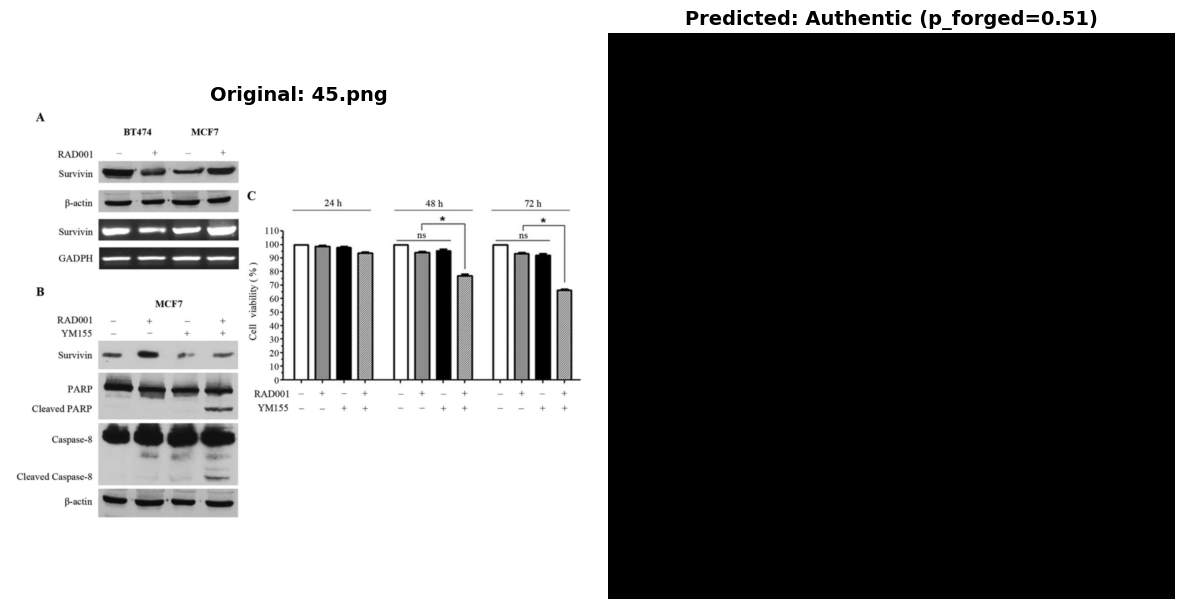

In [20]:
model.eval()

# Take the first file from the test folder
test_files = sorted(os.listdir(paths['test_images']))
file = test_files[0]
img_path = os.path.join(paths['test_images'], file)

# Load image
image = Image.open(img_path).convert('RGB')
image_np = np.array(image)

# Transformations
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

transformed = transform(image=image_np)
image_tensor = transformed['image'].unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image_tensor)   # list of length 1
out = outputs[0]

masks = out["masks"]                     # [K, Hm, Wm], uint8 {0,1}
mask_scores = out["mask_scores"]        # [K]
forgery_scores = out["mask_forgery_scores"]  # [K]
img_forged_prob = out["image_authenticity"]  # scalar in [0,1]

# Thresholds
forgery_threshold = 0.5   # per-mask forgery score
auth_threshold = 0.5       # image-level authenticity gate

# Decide valid detections
if masks.shape[0] == 0 or img_forged_prob < auth_threshold:
    # Authenticity gate or no masks -> predicted authentic
    valid_detections = torch.zeros(0, dtype=torch.bool, device=masks.device)
else:
    valid_detections = forgery_scores > forgery_threshold  # [K]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original
axes[0].imshow(image_np)
axes[0].set_title(f'Original: {file}', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Mask side
if valid_detections.numel() == 0 or valid_detections.sum() == 0:
    combined_mask = np.zeros((256, 256), dtype=np.float32)
    title = f'Predicted: Authentic (p_forged={img_forged_prob:.2f})'
    cmap = 'gray'
else:
    # Combine predicted forgery masks, upsample to 256x256 for display
    combined_mask = np.zeros((256, 256), dtype=np.float32)
    for idx in torch.nonzero(valid_detections, as_tuple=False).flatten():
        mk = masks[idx].float().cpu().numpy()  # [Hm, Wm]
        # Resize to 256x256 for visualization
        mk_resized = cv2.resize(mk, (256, 256), interpolation=cv2.INTER_NEAREST)
        combined_mask = np.maximum(combined_mask, mk_resized)

    title = (
        f'Predicted: Forged ({valid_detections.sum().item()} regions, '
        f'p_forged={img_forged_prob:.2f})'
    )
    cmap = 'hot'

im = axes[1].imshow(combined_mask, cmap=cmap, vmin=0, vmax=1)
axes[1].set_title(title, fontsize=14, fontweight='bold')
axes[1].axis('off')

if valid_detections.numel() > 0 and valid_detections.sum() > 0:
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [21]:
submission = pd.read_csv('/kaggle/working/submission.csv')
submission.head()

,case_id,annotation
0,45,authentic
